In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re

# Data Load

In [38]:
tweet_data = pd.read_csv('twitter_csci581.csv', index_col=False, encoding='utf-8')
tweet_data = shuffle(tweet_data)

In [12]:
len(tweet_data[tweet_data['polarity'] == 3])

0

In [8]:
pd.DataFrame.hist(tweet_data, column='polarity')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f14d6448390>]],
      dtype=object)

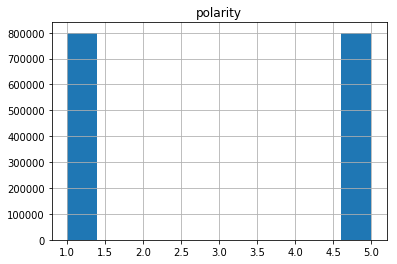

In [10]:
plt.show()

# Data Preprcoessing 

In [3]:
def preprocessTweets(tweet):
    # Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet)

    # Convert @username to __HANDLE
    tweet = re.sub('@[^\s]+', '__HANDLE', tweet)

    # Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    

    # trim
    tweet = tweet.strip('\'"')

    # Repeating words like happyyyyyyyy
    rpt_regex = re.compile(r"(.)\1{1,}", re.IGNORECASE)
    tweet = rpt_regex.sub(r"\1\1", tweet)

    # Emoticons
    emoticons = \
        [
            ('__positive__', [':-)', ':)', '(:', '(-:', \
                              ':-D', ':D', 'X-D', 'XD', 'xD', \
                              '<3', ':\*', ';-)', ';)', ';-D', ';D', '(;', '(-;', ]), \
            ('__negative__', [':-(', ':(', '(:', '(-:', ':,(', \
                              ':\'(', ':"(', ':((', ]), \
            ]

    def replace_parenth(arr):
        return [text.replace(')', '[)}\]]').replace('(', '[({\[]') for text in arr]

    def regex_join(arr):
        return '(' + '|'.join(arr) + ')'

    emoticons_regex = [(repl, re.compile(regex_join(replace_parenth(regx)))) \
                       for (repl, regx) in emoticons]

    for (repl, regx) in emoticons_regex:
        tweet = re.sub(regx, ' ' + repl + ' ', tweet)

        # Convert to lower case
    tweet = tweet.lower()

    return tweet

In [5]:
# def stem(tweet):
#     stemmer = nltk.stem.PorterStemmer()
#     tweet_stem = ''
#     words = [word if (word[0:2] == '__') else word.lower() \
#              for word in tweet.split() \
#              if len(word) >= 3]
#     words = [stemmer.stem(w) for w in words]
#     tweet_stem = ' '.join(words)
#     return tweet_stem

In [39]:
# took 0.2 million sample data
sample_data = tweet_data.sample(n=200000)
sample_data = sample_data.reset_index(drop=True)

In [40]:
tweets = []
for idx, val in sample_data.iterrows():
    text = val['text']
    modified_text = preprocessTweets(text)
    val['modified_tweet'] = modified_text
    val['wtht_eps'] = text.replace("'", '')
    tweets.append(val)

In [41]:
sample_tweet_data = pd.DataFrame(tweets)

In [42]:
len(sample_tweet_data)

200000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5c3f2e4e48>]],
      dtype=object)

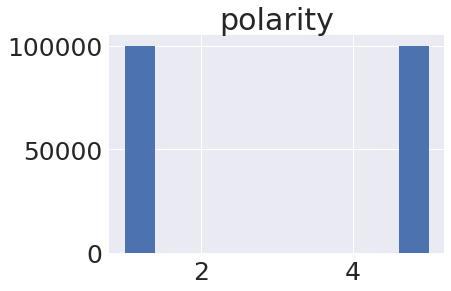

In [112]:
pd.DataFrame.hist(sample_tweet_data, column='polarity')

# Feature Extraction

In [43]:
import re
import pandas as pd
from sklearn.utils import shuffle
import snowballstemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import numpy as np
import pickle
from itertools import product
from nltk import pos_tag
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier

In [44]:
english_stemmer = snowballstemmer.stemmer('english')
file_name = 'tweets'

In [45]:
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: english_stemmer.stemWords(analyzer(doc))

In [46]:
def getNgram(data, n, min_df):
    tfidf_vect = StemmedTfidfVectorizer(min_df=min_df, stop_words='english', analyzer='word', ngram_range=(n,n))
#     TfidfVectorizer(min_df=1, ngram_range=(n,n), stop_words='english')
    sentence_term_tfidf = tfidf_vect.fit_transform(data.modified_tweet)
    sentence_term_df = pd.DataFrame(sentence_term_tfidf.todense(), columns=np.sort(list(tfidf_vect.vocabulary_.keys())))
#     pd.DataFrame(sentence_term_df.columns).to_csv("vocabulary_"+file_name+".txt", encoding='utf-8', index=False)    
    sentence_term_df.columns = sentence_term_df.columns.map(lambda x: 'W_'+str(n)+'_'+x)
#     pickle.dump(tfidf_vect.idf_, open( "models/idf_"+file_name, "wb" )) #storing the vocabulary    
    return sentence_term_df

In [48]:
def getFE(data=None):
    patterns = [r'never|no|nothing|nowhere|noone|none|not|havent|hasnt|hadnt|cant|couldnt|shouldnt|wont|wouldnt|dont|doesnt|didnt|isnt|arent|aint']
    data_fe = pd.DataFrame(columns=range(len(patterns)))
    data_fe.columns = data_fe.columns.map(lambda x: 'FE'+'_'+str(x) )
    for i, pattern in enumerate(patterns):
        data_fe['FE_'+str(i)] = data.wtht_eps.str.contains(pattern)
    return data_fe

In [49]:
data_concat = pd.concat([sample_tweet_data, getNgram(sample_tweet_data, 1, 300)], axis = 1)

In [50]:
data_concat = pd.concat([data_concat, getNgram(sample_tweet_data, 2, 200)], axis = 1)

In [51]:
data_concat = pd.concat([data_concat, getNgram(sample_tweet_data, 3, 50)], axis = 1)

In [52]:
data_concat = pd.concat([data_concat, getFE(sample_tweet_data)], axis = 1)

In [53]:
len(data_concat)

200000

In [113]:
data_concat.shape

(200000, 853)

# Feature Importance

In [99]:
from sklearn.ensemble import RandomForestClassifier

In [103]:
data_regex = data_concat.filter(regex='W_1|W_2|W_3|FE_')
clf = RandomForestClassifier(n_estimators=10)#GaussianNB()#MultinomialNB()#MultinomialNB()#SVC()#LinearSVC()#
clf.fit(data_concat[data_regex.columns], data_concat.polarity)
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

In [104]:
print("Feature ranking:")

for f in range(10):
    print("%d. feature %s (%f)" % (f + 1, data_regex.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature W_1___handl (0.044654)
2. feature FE_0 (0.029245)
3. feature W_1_miss (0.018935)
4. feature W_1_sad (0.016124)
5. feature W_1_thank (0.013189)
6. feature W_1_love (0.012718)
7. feature W_1_good (0.009353)
8. feature W_1_work (0.008637)
9. feature W_1_wish (0.008380)
10. feature W_1_url (0.008378)


/home/mrony/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  # This is added back by InteractiveShellApp.init_path()


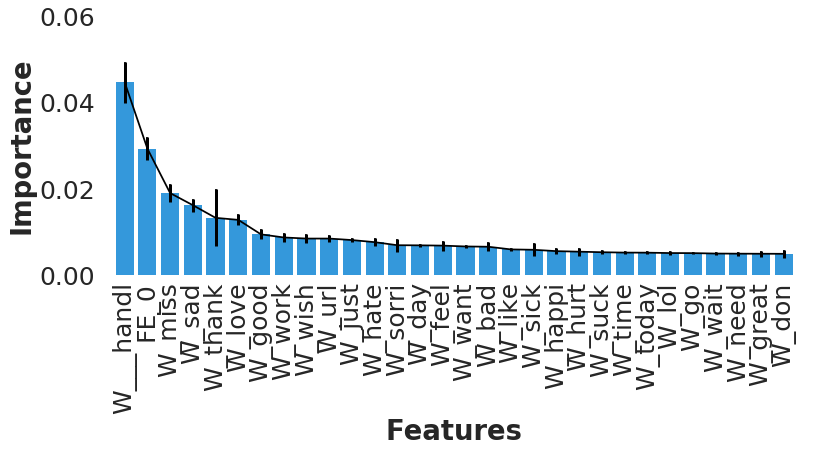

In [105]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set(font_scale=2.5, color_codes=True)

fig, ax = plt.subplots(figsize=(12,7))
plt.xticks(rotation=90)
ax.grid(b=False)
ax.set_axis_bgcolor('white')

features = data_regex.columns

best_k = 30

plt.bar(range(best_k), importances[indices[0:best_k]], color="#3498db", yerr=std[indices[0:best_k]], align="center")

xticks = [tick.replace('_1', '') for tick in features[indices[0:best_k]]]
ax.set_ylim(0, 0.06)
plt.xticks(range(best_k), xticks)
plt.ylabel('Importance', weight = 'bold')
plt.xlabel('Features', weight = 'bold')
plt.xlim([-1, best_k])
plt.errorbar(range(best_k), importances[indices[0:best_k]], color="black", yerr=std[indices[0:best_k]], elinewidth=3)
plt.tight_layout()
plt.savefig('feature_importance.eps', format='eps', dpi=1200)

# Train Test Split

In [54]:
# 33% of 0.2 million 66000
train = data_concat[0:134000]
test = data_concat[134000:]

# Naive Bayes Implementation

In [69]:
import numpy as np
import math

class NaiveBayesClassifier():
    def fit(self, X, y):
        self.X, self.y = X, y
        self.classes = np.unique(y)
        self.parameters = []
        for i, c in enumerate(self.classes):
            X_where_c = X[np.where(y == c)]
            self.parameters.append([])
            for col in X_where_c.T:
                parameters = {"mean": col.mean(), "var": col.var()}
                self.parameters[i].append(parameters)

    def measure_likelihood(self, mean, var, x):
        """ Gaussian likelihood"""
        eps = 1e-4 # Added in denominator to prevent division by zero
        coeff = 1.0 / math.sqrt(2.0 * math.pi * var + eps)
        exponent = math.exp(-(math.pow(x - mean, 2) / (2 * var + eps)))
        return coeff * exponent

    def meausre_prior_probability(self, c):
        X_where_c = self.X[np.where(self.y == c)]
        frequency = len(X_where_c) / len(self.X)
        return frequency

    def apply_classifier(self, sample):
        posteriors = []
        for i, c in enumerate(self.classes):
            posterior = self.meausre_prior_probability(c)
            for feature_value, params in zip(sample, self.parameters[i]):
                likelihood = self.measure_likelihood(params["mean"], params["var"], feature_value)
                posterior *= likelihood
            posteriors.append(posterior)
        # Return the class with the largest posterior probability
        return self.classes[np.argmax(posteriors)]

    def predict(self, X):
        """ Predict the class labels of the samples in X """
        y_pred = [self.apply_classifier(sample) for sample in X]
        return y_pred

# Validation

In [67]:
import sklearn

In [108]:
data_regex = data_concat.filter(regex='W_1|W_2|W_3|FE_')
clf = NaiveBayesClassifier()
clf.fit(train[data_regex.columns].values, train.polarity)
y_pred = clf.predict(test[data_regex.columns].values)

In [109]:
print(sklearn.metrics.classification_report(test.polarity, y_pred))

             precision    recall  f1-score   support

          1       0.74      0.74      0.74     32963
          5       0.74      0.73      0.74     33037

avg / total       0.74      0.74      0.74     66000



In [110]:
print(sklearn.metrics.accuracy_score(test.polarity, y_pred))

0.7381212121212121


# Apply Predictor on Given Tweets

In [87]:
test_data = pd.read_csv('evaluation_csci581.csv', encoding='utf-8', index_col=False)

In [88]:
tweets = []
for idx, val in test_data.iterrows():
    text = val['text']
    modified_text = preprocessTweets(text)
    val['modified_tweet'] = modified_text
    val['wtht_eps'] = text.replace("'", '')
    tweets.append(val)

In [89]:
test_data = pd.DataFrame(tweets)

In [92]:
data_concat = pd.concat([sample_tweet_data, getNgram(test_data, 1, 300)], axis = 1)

In [94]:
data_concat = pd.concat([data_concat, getNgram(test_data, 2, 200)], axis = 1)

In [95]:
data_concat = pd.concat([data_concat, getNgram(test_data, 3, 50)], axis = 1)

In [96]:
data_concat = pd.concat([data_concat, getFE(test_data)], axis = 1)

In [97]:
data_regex = data_concat.filter(regex='W_1|W_2|W_3|FE_')

In [98]:
y_pred = clf.predict(data_concat[data_regex.columns].values)

In [117]:
pd.DataFrame(y_pred).to_csv("output.csv", index=False)

# Exploratory Analysis

In [114]:
from sklearn.svm import LinearSVC
data_regex = data_concat.filter(regex='W_1|W_2|W_3|FE_')
clf = LinearSVC(C=0.1)
clf.fit(train[data_regex.columns].values, train.polarity)
y_pred = clf.predict(test[data_regex.columns].values)

print(sklearn.metrics.classification_report(test.polarity, y_pred))
print(sklearn.metrics.accuracy_score(test.polarity, y_pred))

             precision    recall  f1-score   support

          1       0.76      0.73      0.74     32963
          5       0.74      0.77      0.75     33037

avg / total       0.75      0.75      0.75     66000

0.7484090909090909


In [116]:
from sklearn.neighbors import KNeighborsClassifier
data_regex = data_concat.filter(regex='W_1|W_2|W_3|FE_')
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(train[data_regex.columns].values, train.polarity)
y_pred = clf.predict(test[data_regex.columns].values)

print(sklearn.metrics.classification_report(test.polarity, y_pred))
print(sklearn.metrics.accuracy_score(test.polarity, y_pred))

             precision    recall  f1-score   support

          1       0.68      0.67      0.68     32963
          5       0.68      0.69      0.68     33037

avg / total       0.68      0.68      0.68     66000

0.6817878787878788
